In [3]:
import pandas as pd
import re
import itertools
from  matplotlib import pyplot as plt
import networkx as nx
import collections
import warnings
import os
import xmltodict

warnings.filterwarnings('ignore')
os.chdir('C:\\Users\\steven.ellingson\\PycharmProjects\\cuny')


This is a dataset of Social Networks within movies via the Harard Dataverse.

https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/T4HBA3

If you saw my last assignment you can see that this is right up my alley!

In [4]:
meta = pd.read_csv('data/movie_galaxies/network_metadata.tab', delimiter='\t')
meta.head()

,GexfID,Title,IMDB_id,ReleaseDate,Slug,WeightedDegree,Modularity,PathLength,Diameter,ClusteringCoefficient,ConnectedComponents,Density,Edges,Characters
0,1,10 Things I Hate About You,tt0147800,1999,10-Things-I-Hate-About-You,"13,040","0,194","1,779","3,000","0,567","3,000","0,233",225,25
1,2,12,tt0488478,2007,12,"4,227","0,517","2,170","3,000","0,610","6,000","0,077",102,42
2,3,Twelve and Holding,tt0417385,2005,Twelve-and-Holding,"7,333","0,473","2,449","4,000","0,593","2,000","0,140",139,26
3,5,127 Hours,tt1542344,2010,127-Hours,"3,833","0,160","1,722","2,000","0,339","4,000","0,152",33,11
4,6,1492: Conquest of Paradise,tt0103594,1992,1492:-Conquest-of-Paradise,"7,941","0,350","2,043","4,000","0,705","1,000","0,153",164,34


I've created the following functions for working with this data.
There is a a file for each movie with the graph data. These functions should allow you to find a movie and create a graph.

In [5]:
f = meta[meta['Title'].str.contains('lord', case=False)]
len(f)
f.Title.str.cat(sep = ',')
f['GexfID'].astype(str) + ': ' + f['Title'] + '\n'

437                             511: Lord of Illusions\n
438    512: The Lord of the Rings: The Fellowship of ...
439    513: The Lord of the Rings: The Return of the ...
440                                   515: Lord of War\n
dtype: object

In [6]:
def load_movie_by_id(id):
    #Take an ID and load the movie into a dictionary.
    with open('data/movie_galaxies/' + str(id) + '.gexf') as fd:
        md = xmltodict.parse(fd.read())
    if (md['gexf']):
        return(md['gexf'])
    
def load_movie_by_keyword(keyword):
    #Search for a movie and load it if it finds only 1.
    #This is super basic, could expand this with some fuzzy text algorithm
    results = meta[meta['Title'].str.contains(keyword, case=False)]
    if len(results)==1:
        print('Found!' + str(results['Title'].iloc[0]))
        return(load_movie_by_id(results['GexfID'].iloc[0]))
    elif len(results) > 1:
        c = results['GexfID'].astype(str) + ': ' + results['Title']
        c.str.cat(sep = ',\n')
        print("Too Many Movies! Use more keywords or select by ID:")
        print(c)
    else:
        print("Didn't Find any movies with those Keywords!")

def get_nodes(md):
    #Takes the loaded dictionary and returns a dictionary of the nodes
    
    #Create a blank Data Frame
    d = dict()
    
    #Loop through and add the id and label
    for x in md['graph']['nodes']['node']:
        d.update({x['@id']: x['@label']})
    return(d)

def get_edges(md, weights = True):
    #Takes the dictionary and returns a list of edges.
    #Each edge is a tuple with the relevant ids and the weight.
    e = []
    i = 0
    for x in md['graph']['edges']['edge']:
        i = i+1
        if weights:
            #Need to dig in a bit further to get the weights        
            weight = 0
            for y in x['attvalues']['attvalue']:
                if (y['@for']=='weight'):
                    weight = float(y['@value'])
            
            if weight < 1:
                #If we didn't find a weight print an error message but set to 1.
                print("No weight Found for node # " + str(i) + "!")
                weight = 1
                
            e.append((x['@source'],x['@target'],weight))
        else:
            e.append((x['@source'],x['@target']))

    return(e)

I decided to attempt to try to start from scratch exploring the graph as well.
Here are some functions for finding information about the graph, including the diameter.

In [7]:
def get_node_edges(node, edges):
    #Pull all the edges for a specific node
    l = [x for x in edges if x[0] == node]
    l2 = [(x[1],x[0],x[2]) for x in edges if x[1] == node and x[0] not in l]
    l.extend(l2)
    return(l)

def build_distance_dict(used_nodes, edges):
    #This will make a dictionary of how far each node is away
    i = max(list(used_nodes.keys()) + [0]) + 1
    
    #flatted used_nodes into usable list
    used_node_list = [item for sublist in list(used_nodes.values()) for item in sublist]
    
    #Pull all the edges, this will be a list of lists of tuples
    node_edge_list = [get_node_edges(x, edges) for x in used_nodes[i-1]]
    
    #flatten that into just a list of the new nodes
    new_nodes = list(set([item[1] for sublist in node_edge_list for item in sublist if item[1] not in used_node_list]))
    
    if len(new_nodes) > 0:
        #append this list in the used_nodes dictionary
        used_nodes.update({i: new_nodes})
        return(build_distance_dict(used_nodes, edges))
    else:
        return(used_nodes)

def distance_dict(node, edges):
    #This just pulls the main function, but is easier to specify
    return(build_distance_dict({0:[node]}, edges))

def node_max_dist(node, edges):
    #get the maximum distance for any node, using the above function
    return(len(distance_dict(node,edges)) - 1)

def graph_diameter(nodes, edges):
    dist_list = [node_max_dist(x, edges) for x in nodes]
    return(max(dist_list))

In [8]:
def node_path(source, target, edges, labels = None):
    #This may be a weird way of doing this, but I'm going to work backwards from my distance lists to find a path back to the source.
    #This will always pull exactly one path even though there are likely many
    # if you pass in the node dict as "labels" it will return the labels instead of the id
    dd = distance_dict(source,edges)
    l = len(dd) - 1
    dist = None
    path = list()
    
    while l > 0:
        #check if we've found the target yet
        if dist is None:
            if target in dd[l]:
                dist = l
                new_target = target
                path.append(new_target)
                l = l - 1
        #if we had found it previously or just now we can look for the edge
        if dist is not None:
            target_edges = get_node_edges(new_target, edges)
            target_nodes = [x[1] for x in target_edges if x[1] in dd[l]]
            #This will pull all matches. We only need one
            if len(target_nodes) > 0:
                new_target = target_nodes[0]
                path.append(new_target)
        l = l-1
    path.append(source)
    path.reverse()
    if labels is None:
        return(path)
    else:
        return([labels[x] for x in path])


OK so let's load up a movie and see what we have.

In [9]:
fg = load_movie_by_keyword('Gump')
nodes = get_nodes(fg)
list(nodes.items())[:4]

Found!Forrest Gump


[('1907651', 'ABBIE HOFFMAN'),
 ('1910034', 'AGING HIPPIE'),
 ('1907518', 'ANCHORMAN'),
 ('1905792', 'ANNOUNCER')]

In [10]:
edges = get_edges(fg)
edges[:4]

[('1907651', '1904685', 1.0),
 ('1907651', '1907750', 1.0),
 ('1907518', '1904077', 3.0),
 ('1907518', '1906528', 1.0)]

OK let's pick out a character and see what distances we are

In [11]:
print([key + ': ' + val for key, val in nodes.items() if 'DAN' in val] )

['1906528: LT DAN']


In [14]:
dan_dict = distance_dict('1906528', edges)
for key, val in dan_dict.items():
    print(key,': ',','.join(val))


0 :  1906528
1 :  1905792,1908456,1907096,1907518,1910494,1904077,1908399,1907283,1908844,1910447,1909336,1904685,1908340,1906239,1907000,1906597,1907082,1908453,1906003
2 :  1906426,1904992,1905349,1905199,1904104,1905422,1908720,1907651,1908189,1904638,1908156,1907852,1905535,1905834,1910388,1908875,1907531,1909821,1905178,1909955,1907867,1908203,1906326,1905664,1909281,1906291,1905084,1908918,1907616,1904161,1910401,1905304,1905327,1904641,1904889,1907881,1906313,1907575,1910391,1907864,1907510,1905492,1909981,1905107,1905279,1906258,1906294,1907476,1909515,1904484,1910034,1905913,1909780,1904138,1904610,1907579,1906309,1905131,1907750,1907326,1910087,1908544,1906131,1910323,1906298,1904292,1906086,1906207,1904675,1904649,1910284,1908047,1908697
3 :  1905294


So our furthest distance is 3.  Let's make sure the distance function tells us the same thing.

In [11]:
node_max_dist('1906528', edges)

3

Let's see what the graph diameter is

In [12]:
graph_diameter(nodes, edges)

4

I'm curious what characters are 4 edges apart. Let's loop through and see!

In [13]:
for key,val in nodes.items():
    dd = distance_dict(key, edges)
    if 4 in dd:
        path = [print('->'.join(node_path(key,n, edges, nodes))) for n in dd[4]]

GOVERNOR WALLACE->CHET HUNTLEY->FORREST->LT DAN->MARGO
MARGO->ANCHORMAN->FORREST->CHET HUNTLEY->GOVERNOR WALLACE


OK, so we have just 1 path that is 4 edges long, Margo to Governer Wallace.
Let's create our graph using NetworkX.

In [16]:
G=nx.Graph()
G.add_weighted_edges_from(edges)
G = nx.relabel_nodes(G,nodes, copy=False)

Let's verify my formulas using the built in diameter function.

In [17]:
nx.diameter(G)

4

In [18]:
#asdf = nx.all_shortest_paths(G,'GOVERNOR WALLACE','MARGO')
[print('->'.join(p)) for p in nx.all_shortest_paths(G,'GOVERNOR WALLACE','MARGO')]

GOVERNOR WALLACE->NEWSMAN->JENNY->LT DAN->MARGO
GOVERNOR WALLACE->NEWSMAN->FORREST->LT DAN->MARGO
GOVERNOR WALLACE->CHET HUNTLEY->FORREST->LT DAN->MARGO
GOVERNOR WALLACE->NEWSMAN->FORREST->ANCHORMAN->MARGO
GOVERNOR WALLACE->CHET HUNTLEY->FORREST->ANCHORMAN->MARGO


[None, None, None, None, None]

Perfect! This function pulls all of the shortest paths, but the one my function returned is in there.
Let's draw the graph!

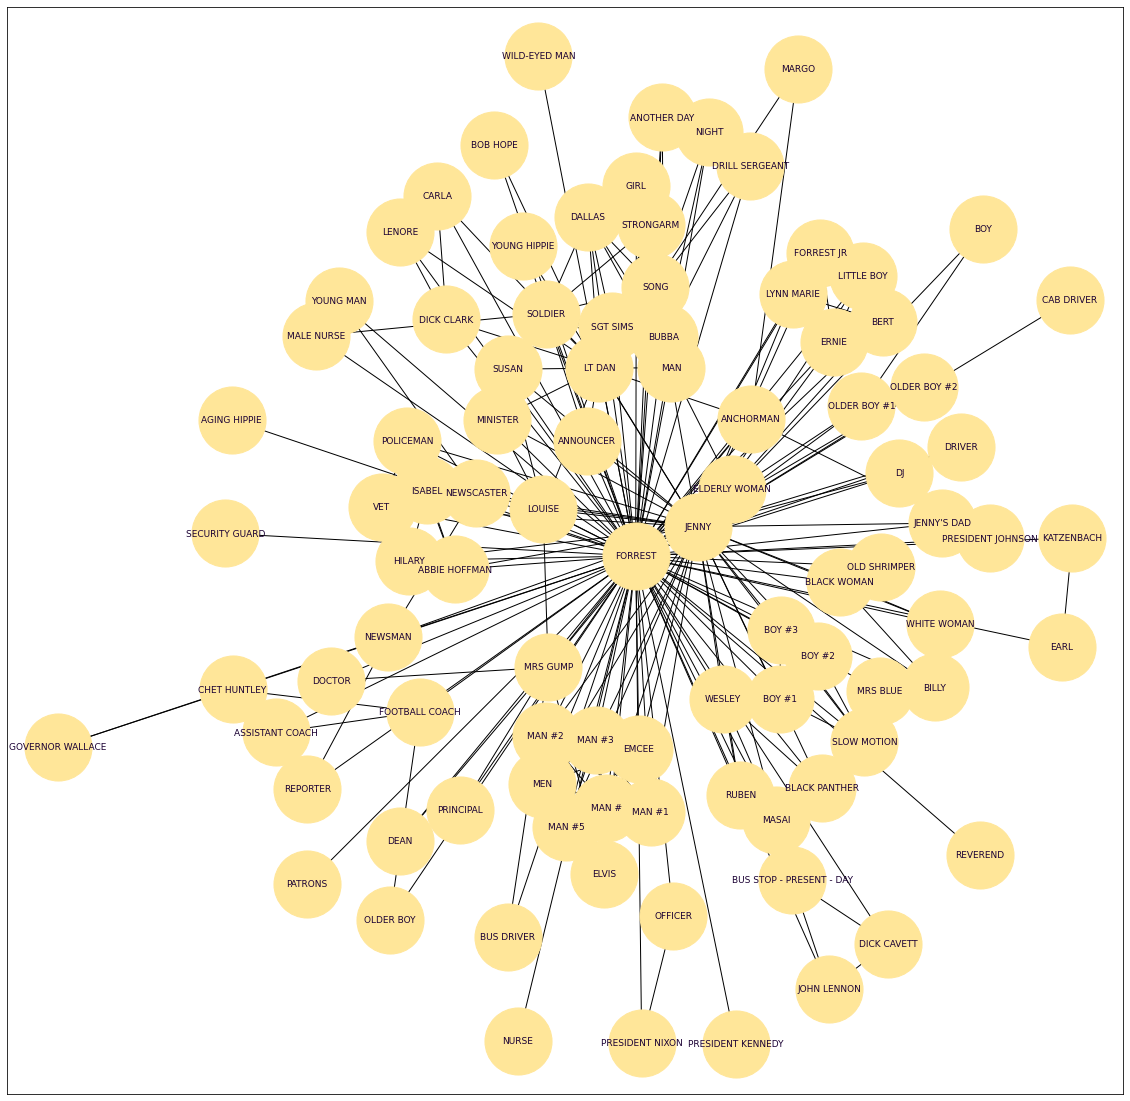

In [19]:
plt.figure(figsize=(20,20))
nx.draw_networkx(G, with_labels=True,
                 node_size = 4500,
                 node_color = '#ffe699',
                 font_size = 9,
                 font_color = '#1a0033'
                 )
plt.show()

